<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC2_FD003_MLP_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%pip install scikeras;
%pip install -U tensorflow-addons;
%pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 37.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 7.5 MB/s 


In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GroupKFold

from sklearn.base import BaseEstimator,RegressorMixin

In [4]:
from skopt import BayesSearchCV

from skopt.space.space import Categorical, Integer, Real

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

from keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare as R2

from scikeras.wrappers import KerasRegressor

In [6]:
sns.set_palette('colorblind')

In [7]:
# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
tf.config.experimental.enable_op_determinism()

In [9]:
# Remove some tf warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Data Preparation

In [10]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    IN_COLAB = True
    folder="/content/CMaps/"

    # Dataset Download 
    os.system('git clone https://github.com/arthursl12/dataset_2')
    os.system('mv /content/dataset_2/CMaps /content/CMaps')
    os.system('mv /content/dataset_2/data_processing /content/data_processing')
    os.system('rm -rf dataset_2')
else:
    print('Not running on CoLab')
    IN_COLAB = False
    folder="CMaps/"
    %cd dataset_2/

Running on CoLab


In [11]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [12]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [13]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(3,folder=folder)
train

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753


## Preprocessing

### Validation Set

In [14]:
from sklearn.model_selection import GroupShuffleSplit

def train_val_split(train):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  
    for idx_train, idx_val in gss.split(train,groups=train["unit_number"]):
        # print('train_split_engines', train.iloc[idx_train]['unit_number'].unique(), '\n')
        # print('validate_split_engines', train.iloc[idx_val]['unit_number'].unique(), '\n')

        df_train = train.iloc[idx_train].copy()
        df_val = train.iloc[idx_val].copy()

    return df_train, df_val

In [15]:
df_train, df_val = train_val_split(train)

In [16]:
X_t_train, y_t_train = proc.X_y_train_divide(df_train)
X_t_val, y_t_val = proc.X_y_train_divide(df_val)

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [17]:
test.shape, y_test.shape

((16596, 26), (100, 1))

In [18]:
test_last = proc.transform_test(test)
test_last.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,642.59,1592.40,1409.87,14.62,21.58,560.53,2388.22,9085.50,1.31,...,528.05,2388.23,8158.77,8.2966,0.03,393,2388,100.0,39.43,23.5679
1,518.67,642.56,1587.42,1409.69,14.62,21.61,553.33,2388.18,9050.97,1.30,...,520.90,2388.17,8128.04,8.4514,0.03,392,2388,100.0,38.83,23.2821
2,518.67,642.75,1591.93,1417.66,14.62,21.60,563.61,2388.31,9091.69,1.31,...,531.36,2388.33,8173.56,8.3057,0.03,395,2388,100.0,39.27,23.6440
3,518.67,642.28,1584.68,1406.56,14.62,21.61,552.75,2388.07,9048.23,1.30,...,521.27,2388.09,8133.78,8.4337,0.03,392,2388,100.0,38.70,23.3804
4,518.67,642.15,1580.59,1397.26,14.62,21.58,553.82,2387.96,9050.89,1.30,...,521.74,2387.96,8132.51,8.3900,0.03,390,2388,100.0,38.89,23.4463


In [19]:
X_test = test_last

### Remaining Useful Life (RUL)

In [20]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

,unit_number,time,RUL
0,1,1,258
1,1,2,257
2,1,3,256
3,1,4,255
4,1,5,254


## Attributes and target separation

In [21]:
X_train, y_train = proc.X_y_train_divide(train)

In [22]:
y_train.head()

,RUL
0,258
1,257
2,256
3,255
4,254


In [23]:
X_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


## Training and Evaluation functions

In [24]:
eval = Evaluation()

In [25]:
search = HyperparameterSearch()

# MLP Construction

## Callbacks

In [26]:
# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                      patience=5, restore_best_weights=True)

In [27]:
# Printing Callback
def printLog(epoch, logs):
    print(
        f"E {epoch+1}\t: loss={logs['loss']:.3f}, "+
        f"rmse={logs['root_mean_squared_error']:.3f}, "+
        f"r2={logs['r_square']:.3f}; "+
        f"v_loss={logs['val_loss']:.3f}, "+
        f"v_rmse={logs['val_root_mean_squared_error']:.3f}, "+
        f"v_r2={logs['val_r_square']:.3f}; "
    )

printerCallback = LambdaCallback(on_epoch_end=printLog)

## Auxiliary HyperParameters

In [28]:
layer_sizes=[16,32,64,128,256,512]

In [29]:
# Exponential Decay Schedules
ED1 = ExponentialDecay(initial_learning_rate=1e-2, name="ED1",
                       decay_steps=100000, decay_rate=0.96)
ED2 = ExponentialDecay(initial_learning_rate=1e-2, name="ED2",
                       decay_steps=100000, decay_rate=0.8)
ED3 = ExponentialDecay(initial_learning_rate=1e-1, name="ED3",
                       decay_steps=100000, decay_rate=0.96)

In [30]:
# Generation of list combinations
from itertools import chain, permutations

def all_permutations(lst, size):
    result = list(chain.from_iterable([permutations(lst, x) for x in range(len(lst)+1)]))
    out = []
    for r in result:
        if (len(r) == size):
            out.append(list(r))
    return out

## Constants

In [31]:
# X_train must include indices
train3 = train.copy()
X_train_ = train3.drop(columns=[index_cols[1]]+["RUL"])

In [32]:
INPUT_SHAPE = 0

## Wrapper

In [33]:
from sys import is_finalizing
from sklearn.metrics import r2_score

class MLPWrapperRegressor(BaseEstimator,RegressorMixin):
    def __init__(self, basemodel=None, clip_y=-1,
                 include_settings=False, poly_degree=1,
                 scaler=StandardScaler()):
        # Base parameters
        self.basemodel = basemodel
        self.clip_y = clip_y
        self.poly_degree = poly_degree
        self.include_settings = include_settings

        # Column indexers
        self.feature_cols = sensors_cols
        if(include_settings):
            self.feature_cols = settings_cols + self.feature_cols
        self.base_feature_cols = self.feature_cols

        # Scaler and PolyFeatures transformers
        self.scaler = scaler
        self.polyft = PolynomialFeatures(degree=self.poly_degree, 
                                         include_bias=False)

    def clean_cols(self,df):
        if("unit_number" in df.columns): del df["unit_number"]
        if("unit_number" in df.columns): del df["unit_number"]
        if("time" in df.columns): del df["time"]
        if((not self.include_settings)): 
            for col in settings_cols:
                if(col in df.columns): del df[col]
        return df

    def fit(self, X=None, y=None):
        # Drop irrelevant column
        data = pd.DataFrame(X).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.fit_transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.fit_transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        X_train = data.copy()
        
        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_train = data2

        # Update input shape for future use
        global INPUT_SHAPE
        INPUT_SHAPE = X_train.shape[1]

        # Fit model
        self.basemodel.fit(X_train,y_train)
        return self
        
    def predict(self, X=None):
        # Perform transformation, if not done
        if (len(X.columns) != len(self.feature_cols)):
            X_train = self.transform_features(X)
        else:
            X_train = X
        return self.basemodel.predict(X_train)

    def transform_features(self, df):
        # Drop irrelevant column
        data = pd.DataFrame(df).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        # self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        return data

    def score(self, X, y, sample_weight=None):
        X_test = self.transform_features(X)

        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_test = data2

        # Predict on test data
        y_pred = self.predict(X_test)
        return r2_score(y_test, y_pred, sample_weight=sample_weight)

## Test Data

In [34]:
def scale_test(test,model):
    test2 = pd.DataFrame(test)
    test2 = model.clean_cols(test2)

    # Apply polynomial features
    transf = model.polyft.transform(test2)
    test2 = pd.DataFrame(transf, 
                         columns=model.polyft.get_feature_names_out())

    # Scale the data (with train data parameters)
    test2 = model.scaler.transform(test2)
    test2 = pd.DataFrame(test2, 
                         columns=model.polyft.get_feature_names_out())
    return test2

## Constructor

In [35]:
def create_model(optim=Adam, learning_rate=1e-3, 
                 layer1=32  , activation1="tanh"    , dropout1=0.1,
                 layer2=None, activation2="tanh"    , dropout2=0.1,
                 layer3=None, activation3="tanh"    , dropout3=0.1,
                 layer4=None, activation4="tanh"    , dropout4=0.1,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Fully Connected Layer
    model.add(Dense(layer1, input_dim=INPUT_SHAPE, activation=activation1))
    model.add(Dropout(dropout1))

    # Additional hidden layers
    if(layer2 is not None):
        model.add(Dense(layer2, activation=activation2))
        model.add(Dropout(dropout2))
        if (layer3 is not None):
            model.add(Dense(layer3, activation=activation3))
            model.add(Dropout(dropout3))
            if (layer4 is not None):
                model.add(Dense(layer4, activation=activation4))
                model.add(Dropout(dropout4))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

# HyperParameter Tuning

In [61]:
CLIP=126

model = MLPWrapperRegressor(
        clip_y=CLIP,scaler=MinMaxScaler(),
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=64,
                           epochs=1,
                           validation_split=0.2, 
                           model__layer1=512, 
                           model__activation1='relu',
                           model__dropout1=0.5, 
                           model__layer2=64,
                           model__layer3=64,
                           model__layer4=64,
                           model__learning_rate=0.01,
                           model__optim=Adam,
                        #    verbose=0, callbacks=[es,printerCallback],
                           verbose=0, callbacks=[es],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=False
                           )
    )

In [62]:
# ~3h (LSTM)
# ~45min (MLP)
GRID_SEARCH = True
if (GRID_SEARCH):
    param_distributions = {
        "clip_y": Integer(80,140),
        "poly_degree": Categorical([2,3]),
        "scaler": Categorical([MinMaxScaler(),StandardScaler()]),
        "basemodel__epochs": Integer(1,50),
        "basemodel__validation_split":Real(0.1,0.9),
        "basemodel__batch_size": Integer(32,512),
        "basemodel__model__optim":Categorical([Adam,RMSprop]),
        "basemodel__model__learning_rate": Real(1e-4, 1e-2),
        
        "basemodel__model__layer1": Integer(16,512),
        "basemodel__model__activation1": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout1": Real(0.1,0.9),

        "basemodel__model__layer2": Integer(16,512),
        "basemodel__model__activation2": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout2": Real(0.1,0.9),

        "basemodel__model__layer3": Integer(16,512),
        "basemodel__model__activation3": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout3": Real(0.1,0.9),

        "basemodel__model__layer4": Integer(16,512),
        "basemodel__model__activation4": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout4": Real(0.1,0.9),
    }
    gcv = GroupKFold(n_splits=3)
    groups=X_train_['unit_number']
    bss = BayesSearchCV(model, param_distributions, 
                        verbose=3, n_jobs=1, refit=False,
                        cv=gcv.split(X_train_, groups=groups), n_iter=45)
    model = bss.fit(X_train_, y_train)
    
    # print(bss.best_estimator_)
    print("Finished:", datetime.datetime.now())

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END basemodel__batch_size=377, basemodel__epochs=6, basemodel__model__activation1=relu, basemodel__model__activation2=relu, basemodel__model__activation3=selu, basemodel__model__activation4=sigmoid, basemodel__model__dropout1=0.8304688237422622, basemodel__model__dropout2=0.8807502827514379, basemodel__model__dropout3=0.26003789933182353, basemodel__model__dropout4=0.6140737877024202, basemodel__model__layer1=98, basemodel__model__layer2=457, basemodel__model__layer3=401, basemodel__model__layer4=432, basemodel__model__learning_rate=0.004787599953642966, basemodel__model__optim=<class 'keras.optimizers.optimizer_v2.adam.Adam'>, basemodel__validation_split=0.734323552850562, clip_y=114, poly_degree=2, scaler=MinMaxScaler();, score=-0.071 total time=   2.0s
[CV 2/3] END basemodel__batch_size=377, basemodel__epochs=6, basemodel__model__activation1=relu, basemodel__model__activation2=relu, basemodel__model__activation3=sel

In [63]:
# print(bss.best_estimator_)
print(bss.best_score_)
print(bss.best_params_)
print("Finished:", datetime.datetime.now())

0.8644256248735079
OrderedDict([('basemodel__batch_size', 69), ('basemodel__epochs', 48), ('basemodel__model__activation1', 'relu'), ('basemodel__model__activation2', 'sigmoid'), ('basemodel__model__activation3', 'relu'), ('basemodel__model__activation4', 'selu'), ('basemodel__model__dropout1', 0.7861582092207701), ('basemodel__model__dropout2', 0.1651211488004366), ('basemodel__model__dropout3', 0.3806276727312806), ('basemodel__model__dropout4', 0.5407685563014424), ('basemodel__model__layer1', 335), ('basemodel__model__layer2', 352), ('basemodel__model__layer3', 87), ('basemodel__model__layer4', 110), ('basemodel__model__learning_rate', 0.0013462596203423387), ('basemodel__model__optim', <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>), ('basemodel__validation_split', 0.40880873684195296), ('clip_y', 84), ('poly_degree', 3), ('scaler', StandardScaler())])
Finished: 2022-10-23 20:03:11.300639


Finished: 2022-10-23 20:03:11.331925


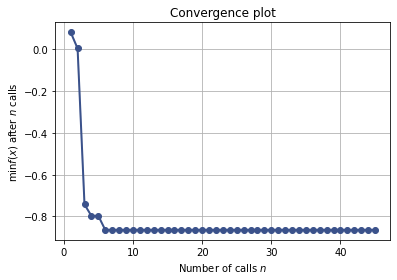

In [64]:
from skopt.plots import plot_convergence

plot_convergence(bss.optimizer_results_)
print("Finished:", datetime.datetime.now())

In [65]:
bss.best_params_

OrderedDict([('basemodel__batch_size', 69),
             ('basemodel__epochs', 48),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'relu'),
             ('basemodel__model__activation4', 'selu'),
             ('basemodel__model__dropout1', 0.7861582092207701),
             ('basemodel__model__dropout2', 0.1651211488004366),
             ('basemodel__model__dropout3', 0.3806276727312806),
             ('basemodel__model__dropout4', 0.5407685563014424),
             ('basemodel__model__layer1', 335),
             ('basemodel__model__layer2', 352),
             ('basemodel__model__layer3', 87),
             ('basemodel__model__layer4', 110),
             ('basemodel__model__learning_rate', 0.0013462596203423387),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.408808736841952

# MLP 1-layer



## Linear RUL

Score: 0.6216329789186076  
Test: 0.
```
('basemodel__batch_size', 140),
             ('basemodel__epochs', 40),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__dropout1', 0.6738055381845307),
             ('basemodel__model__layer1', 274),
             ('basemodel__model__learning_rate', 0.0026697581512638087),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('scaler', StandardScaler())
```







## Non-Linear RUL
Score: 0.8769850696112492  
Test: 0.
```
('basemodel__batch_size', 32),
             ('basemodel__epochs', 47),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__dropout1', 0.1),
             ('basemodel__model__layer1', 512),
             ('basemodel__model__learning_rate', 0.004394643527896066),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('clip_y', 80),
             ('scaler', MinMaxScaler())
```



## Linear RUL + Poly
Score: 0.623044428465008  
Test: 0.
```
('basemodel__batch_size', 114),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__dropout1', 0.8089278925268311),
             ('basemodel__model__layer1', 453),
             ('basemodel__model__learning_rate', 0.00336601478011081),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.11337798870650495),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```



## Non-Linear RUL + Poly
Score: 0.8488892610573798  
Test: 0.
```
('basemodel__batch_size', 97),
             ('basemodel__epochs', 24),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__dropout1', 0.15096258494167586),
             ('basemodel__model__layer1', 264),
             ('basemodel__model__learning_rate', 0.0040754761072153145),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.17873567459530804),
             ('clip_y', 105),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```

# MLP 2-layer



## Linear RUL

Score: 0.6117982346232361  
Test: 0.
```
('basemodel__batch_size', 215),
             ('basemodel__epochs', 31),
             ('basemodel__model__activation1', 'sigmoid'),
             ('basemodel__model__activation2', 'elu'),
             ('basemodel__model__dropout1', 0.535540507143301),
             ('basemodel__model__dropout2', 0.2838929138188482),
             ('basemodel__model__layer1', 62),
             ('basemodel__model__layer2', 401),
             ('basemodel__model__learning_rate', 0.002945657435413331),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.3558423584914324),
             ('scaler', StandardScaler())
```






## Non-Linear RUL
Score: 0.8675039655819224  
Test: 0.
```
('basemodel__batch_size', 164),
             ('basemodel__epochs', 29),
             ('basemodel__model__activation1', 'elu'),
             ('basemodel__model__activation2', 'tanh'),
             ('basemodel__model__dropout1', 0.8791215719915316),
             ('basemodel__model__dropout2', 0.1),
             ('basemodel__model__layer1', 511),
             ('basemodel__model__layer2', 512),
             ('basemodel__model__learning_rate', 0.009861716088609234),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('clip_y', 80),
             ('scaler', StandardScaler())
```


## Linear RUL + Poly
Score: 0.6119811339203444  
Test: 0.
```
('basemodel__batch_size', 477),
             ('basemodel__epochs', 49),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__dropout1', 0.18510920905532013),
             ('basemodel__model__dropout2', 0.2129692928941368),
             ('basemodel__model__layer1', 420),
             ('basemodel__model__layer2', 241),
             ('basemodel__model__learning_rate', 0.009500210759954515),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.11902117833628473),
             ('poly_degree', 3),
             ('scaler', MinMaxScaler())
```



## Non-Linear RUL + Poly
Score: 0.8797075116940171  
Test: 0.
```
('basemodel__batch_size', 32),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'elu'),
             ('basemodel__model__dropout1', 0.1),
             ('basemodel__model__dropout2', 0.1),
             ('basemodel__model__layer1', 461),
             ('basemodel__model__layer2', 512),
             ('basemodel__model__learning_rate', 0.0001),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('clip_y', 80),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```

# MLP 3-layer


## Linear RUL

Score: 0.6031587839965488    
Test: 0.
```
('basemodel__batch_size', 273),
             ('basemodel__epochs', 18),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__activation2', 'tanh'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__dropout1', 0.8779935839787812),
             ('basemodel__model__dropout2', 0.10779365305325281),
             ('basemodel__model__dropout3', 0.4510533904028945),
             ('basemodel__model__layer1', 244),
             ('basemodel__model__layer2', 341),
             ('basemodel__model__layer3', 104),
             ('basemodel__model__learning_rate', 0.006744014727126686),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.1),
             ('scaler', MinMaxScaler())
```




## Non-Linear RUL
Score: 0.8606739658341226    
Test: 0.
```
('basemodel__batch_size', 246),
             ('basemodel__epochs', 34),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'relu'),
             ('basemodel__model__dropout1', 0.398822951109552),
             ('basemodel__model__dropout2', 0.3447841740069549),
             ('basemodel__model__dropout3', 0.9),
             ('basemodel__model__layer1', 142),
             ('basemodel__model__layer2', 454),
             ('basemodel__model__layer3', 370),
             ('basemodel__model__learning_rate', 0.00337864526028697),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.433392689037953),
             ('clip_y', 80),
             ('scaler', StandardScaler())
```



## Linear RUL + Poly
Score: 0.6144434017693393    
Test: 0.
```
('basemodel__batch_size', 392),
             ('basemodel__epochs', 25),
             ('basemodel__model__activation1', 'sigmoid'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__dropout1', 0.26670195337882074),
             ('basemodel__model__dropout2', 0.14342309787217927),
             ('basemodel__model__dropout3', 0.3763758002816012),
             ('basemodel__model__layer1', 211),
             ('basemodel__model__layer2', 16),
             ('basemodel__model__layer3', 398),
             ('basemodel__model__learning_rate', 0.005523882705085696),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('poly_degree', 2),
             ('scaler', MinMaxScaler())
```



## Non-Linear RUL + Poly
Score: 0.8700749435053768   
Test: 0.
```
('basemodel__batch_size', 403),
             ('basemodel__epochs', 30),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'elu'),
             ('basemodel__model__dropout1', 0.4446452001317711),
             ('basemodel__model__dropout2', 0.6178728243917544),
             ('basemodel__model__dropout3', 0.48882961847253814),
             ('basemodel__model__layer1', 310),
             ('basemodel__model__layer2', 273),
             ('basemodel__model__layer3', 114),
             ('basemodel__model__learning_rate', 0.007023482013202204),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.2747333733591927),
             ('clip_y', 90),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```

# MLP 4-layer 


## Linear RUL

Score: 0.5965333341401537    
Test: 0.
```
('basemodel__batch_size', 66),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__activation4', 'relu'),
             ('basemodel__model__dropout1', 0.8385437522647914),
             ('basemodel__model__dropout2', 0.23198581914083677),
             ('basemodel__model__dropout3', 0.1),
             ('basemodel__model__dropout4', 0.18918890917273032),
             ('basemodel__model__layer1', 291),
             ('basemodel__model__layer2', 117),
             ('basemodel__model__layer3', 147),
             ('basemodel__model__layer4', 248),
             ('basemodel__model__learning_rate', 0.01),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.14404412076041206),
             ('scaler', MinMaxScaler())
```





## Non-Linear RUL
Score: 0.862360484973761    
Test: 0.
```
('basemodel__batch_size', 141),
             ('basemodel__epochs', 36),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'sigmoid'),
             ('basemodel__model__activation4', 'selu'),
             ('basemodel__model__dropout1', 0.6030375513292561),
             ('basemodel__model__dropout2', 0.404789057124993),
             ('basemodel__model__dropout3', 0.6692037092668784),
             ('basemodel__model__dropout4', 0.5529044823633812),
             ('basemodel__model__layer1', 342),
             ('basemodel__model__layer2', 86),
             ('basemodel__model__layer3', 353),
             ('basemodel__model__layer4', 80),
             ('basemodel__model__learning_rate', 0.0035609790280109383),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.12093724706982273),
             ('clip_y', 89),
             ('scaler', StandardScaler())
```



## Linear RUL + Poly
Score: 0.5965860921885896    
Test: 0.
```
('basemodel__batch_size', 297),
             ('basemodel__epochs', 4),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'elu'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__activation4', 'relu'),
             ('basemodel__model__dropout1', 0.5444566159296994),
             ('basemodel__model__dropout2', 0.4338236298382706),
             ('basemodel__model__dropout3', 0.7048318485513446),
             ('basemodel__model__dropout4', 0.17180189230876136),
             ('basemodel__model__layer1', 458),
             ('basemodel__model__layer2', 113),
             ('basemodel__model__layer3', 161),
             ('basemodel__model__layer4', 494),
             ('basemodel__model__learning_rate', 0.0006019662806120351),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.572593134337274),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```



## Non-Linear RUL + Poly
Score: 0.8644256248735079  
Test: 0.
```
('basemodel__batch_size', 69),
             ('basemodel__epochs', 48),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'relu'),
             ('basemodel__model__activation4', 'selu'),
             ('basemodel__model__dropout1', 0.7861582092207701),
             ('basemodel__model__dropout2', 0.1651211488004366),
             ('basemodel__model__dropout3', 0.3806276727312806),
             ('basemodel__model__dropout4', 0.5407685563014424),
             ('basemodel__model__layer1', 335),
             ('basemodel__model__layer2', 352),
             ('basemodel__model__layer3', 87),
             ('basemodel__model__layer4', 110),
             ('basemodel__model__learning_rate', 0.0013462596203423387),
             ('basemodel__model__optim',
              keras.optimizers.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.40880873684195296),
             ('clip_y', 84),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```

# MLP Tester



```
('basemodel__batch_size', 32),
('basemodel__epochs', 50),
('basemodel__model__activation1', 'tanh'),
('basemodel__model__activation2', 'elu'),
('basemodel__model__dropout1', 0.1),
('basemodel__model__dropout2', 0.2107518503547072),
('basemodel__model__layer1', 168),
('basemodel__model__layer2', 428),
('basemodel__model__learning_rate', 0.01),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.13631332793413636),
('clip_y', 80),
('scaler', MinMaxScaler())
```



In [ ]:
CLIP=80

model = MLPWrapperRegressor(
        clip_y=CLIP, scaler=MinMaxScaler(),
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=50,
                           model__activation1='tanh',
                           model__activation2='elu',
                           model__dropout1=0.1,
                           model__dropout2=0.2107518503547072, 
                           model__layer1=168, 
                           model__layer2=428, 
                           model__learning_rate=0.01,
                           model__optim=Adam,
                           validation_split=0.13631332793413636, 
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

Model: "sequential_270"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_810 (Dense)           (None, 168)               3696      
                                                                 
 dropout_540 (Dropout)       (None, 168)               0         
                                                                 
 dense_811 (Dense)           (None, 428)               72332     
                                                                 
 dropout_541 (Dropout)       (None, 428)               0         
                                                                 
 dense_812 (Dense)           (None, 1)                 429       
                                                                 
Total params: 76,457
Trainable params: 76,457
Non-trainable params: 0
_________________________________________________________________
E 1	: loss=172.561, rmse=13.136, r2=0.712; v_los

MLPWrapperRegressor(basemodel=KerasRegressor(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x0000017111EAD250>, <keras.callbacks.LambdaCallback object at 0x0000017111EE4C10>], epochs=50, model=<function create_model at 0x0000017111F378B0>, model__activation1='tanh', model__activation2='elu', model__dropout1=0.1, model__dropout2=0.21075185035470...=428, model__learning_rate=0.01, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x00000172AC584D90>, <tensorflow_addons.metrics.r_square.RSquare object at 0x00000172AC584C10>], model__optim=<class 'keras.optimizer_v2.adam.Adam'>, print_summary=True, validation_split=0.13631332793413636, verbose=0),
                    clip_y=80, scaler=MinMaxScaler())

In [ ]:
model.score(X_test, reclipped_y)

NameError: ignored

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(X_test,model)
# test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH)

# Clipping test labels
reclipped_y = y_test.copy()
if (CLIP > 0): reclipped_y=reclipped_y["RUL"].clip(upper=CLIP)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_sc))
# eval.show_result(reclipped_y, model.predict(X_test)) ## Doesn't work for LSTM
print("Finished:", datetime.datetime.now())

NotFittedError: ignored